In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sklearn
import matplotlib.pyplot as plt
import seaborn as sb
import imblearn

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

##### Read the dataset

In [ ]:
credit_churn_dataset= pd.read_csv('credit_card_churn.csv')
credit_churn_dataset.head()

In [ ]:
print(credit_churn_dataset.columns)

In [ ]:
#### drop off the last 2 columns [ as they are not neccessary]
credit_churn_dataset.drop(['Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1','Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2'],axis=1,inplace=True)

In [ ]:
credit_churn_dataset.head()

In [ ]:
#### here Attrition_Flag is the dependent variable
#### first let's split the data into train and test and then use the train for further analysis
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test= train_test_split(credit_churn_dataset.drop('Attrition_Flag',axis=1),credit_churn_dataset['Attrition_Flag'],random_state=0,test_size=0.2,stratify=credit_churn_dataset['Attrition_Flag'])
train_df= pd.concat([X_train,y_train],axis=1)

In [ ]:
X_test_copy= X_test.copy()
y_test_copy= y_test.copy()

In [ ]:
train_df.head()

In [ ]:
#### now we will be using train_df for studying the dataset, doing eda and training the model/algorithm

In [ ]:
train_df.info()

#### Observations

1. No missing values were observed

2. gender, education level,martial status, income category, card category are datatype object, so they would be categorical features

In [ ]:
#### finding the missing values
train_df.isnull().sum()

##### there is no missing values in train_dataset

In [ ]:
X_test.isnull().sum()

##### There is no missing values in test dataset 

#### Exploratory Data Analysis

In [ ]:
train_df.describe()

In [ ]:
#### find the propotion of Attrion Flag in train_df data
plt.figure(figsize=(12,8))
sb.countplot(data=train_df,x='Attrition_Flag')
plt.title('Count of attrition flag in train data')
plt.show()

##### Observations

1. Attrited Customer is in low number then existing customer (around 7 times)

2. It can be considered as the case of imbalanced dataset

In [ ]:
#### drawing the plot of object columns count with respect to Attrition_Flag
cols= list(train_df.select_dtypes(object).columns)
cols.remove('Attrition_Flag')
for i in cols:
    plt.figure(figsize=(12,8))
    sb.countplot(data=train_df,x=i)
    plt.title(f'Count of train_df with respect to {i} feature')
    plt.show()
    


##### Observations

1. Except Gender count plot, all other count plot were not uniformly distributed.

2. For card category, Blue card has most count, while rest others are having least count

In [ ]:
##### Taking the count based on dependents
i='Dependent_count'
plt.figure(figsize=(12,8))
sb.countplot(data=train_df,x=i)
plt.title(f'Count of  {i} in train data')
plt.show()
    

#### Observations

1. Dependent count has non-uniform distribution

In [ ]:
cont_cols= list(train_df.select_dtypes(['int64','float64']).columns)
cont_cols.remove('CLIENTNUM')

In [ ]:
for i in cont_cols:
    plt.figure(figsize=(12,8))
    sb.distplot(train_df[i],kde=True)
    plt.title(f'Distribution of data for {i}')
    plt.show()
    
    

##### Observations

1. From the distribution, it could see that from the training dataset, customer age are coming in between 40-50

2.  Dependent count is multimodal, but looks symmetrical from both sides

3. Months on books is normal distribution where data is more b/w 30-50

4. Total Relationship count is multimodal

5. Months_inactive_12months is multimodal and if left skewed

6. Contacts_count_12_mon is multimodal and left skewed

7. Credit_Limit is left skewed distribution having more credit limit in range <5000 

8. Total_Revolving_Balance is multimodal with most revolving balance b/w 0 and at near around 1500

9. Avg_Open_To_Buy has left skewed distribution with most data near to zero

10. Total amt_change Q4_over_Q1 is left skewed with most being b/w 0.5 and 1.0 which also indicates, transaction has been less in Q4 comparing with Q1

11. Total_Trans_Amt over last 12 months distribution is multmodal with left skewed 

12. Total_Trans_Ct has bimodal distribution

13. Total_Trans_Chng_Q4_Q1 has left skewed distribution mostly ranging between 0.5 and 1.0, which indicates most transaction are less in Q4 comparing with Q1

14. Average_Card_Utlization_Ratio has left skewed distribution, mostly between 0.3 and 0.0 which itself is good (good card utlization is <=0.3) 

In [ ]:
train_df.groupby('Income_Category').aggregate({'Card_Category':'value_counts'})

In [ ]:
#### taking the count of income category with respect to card category
plt.figure(figsize=(12,8))
sb.countplot(data=train_df,x='Income_Category',hue='Card_Category')
plt.title('Income Category with respect to card category count plot')
plt.show()

#### Observations

For all income categories, Blue card is preffered most than others

In [ ]:
df1=train_df.groupby('Income_Category').aggregate({'Avg_Utilization_Ratio':'mean'})
cols=['Unknown','Less than $40K','$40K - $60K','$60K - $80K','$80K - $120K','$120K +']
plt.figure(figsize=(12,8))
sb.barplot(data=df1,x=df1.index,y=df1['Avg_Utilization_Ratio'],order=cols)
plt.title('Average_Card_Utlization Ratio with respect to card category')
plt.show()

#### Observations

1. Except for unknown, other category trend is as followa, as income range increases, Credit_Utilization_Ratio decreases

In [ ]:
df2= train_df.groupby('Card_Category').aggregate({'Total_Relationship_Count':pd.Series.mode})
df2.columns=['Relationship count max occured']
df2

In [ ]:
plt.figure(figsize=(12,8))
sb.barplot(data=df1,x=df2.index,y=df2['Relationship count max occured'])
plt.title('Most Products held  with respect to card category')
plt.show()

#### Observations

1. Blue and platinum card taken most products out of bank while others has taken around 2

In [ ]:
df2= train_df.groupby('Income_Category').aggregate({'Total_Relationship_Count':pd.Series.mode})
df2.columns=['Relationship count max occured']
cols=['Unknown','Less than $40K','$40K - $60K','$60K - $80K','$80K - $120K','$120K +']
plt.figure(figsize=(12,8))
sb.barplot(data=df2,x=df2.index,y=df2['Relationship count max occured'],order=cols)
plt.title('Most products taken with respect to income category')
plt.show()

#### Observations

1. All are equally same for all income category

In [ ]:
plt.figure(figsize=(12,8))
plt.scatter(train_df['Months_on_book'],train_df['Total_Relationship_Count'])
plt.title('Total products held w.r.t Months on book')
plt.xlabel('Months_on_book')
plt.ylabel('Total_Relationship_count')
plt.show()

#### Observations

1. There is no relation between month_on_book and Total_Relationship_count

In [ ]:
plt.figure(figsize=(12,8))
sb.barplot(data=train_df,x='Income_Category',y='Total_Revolving_Bal',order=cols)
plt.title('Total Revolving Balance with income category')

#### Observations

1. No realtion found , as all income categories has same almost revolving balance


In [ ]:
cat_cols= list(train_df.select_dtypes(object).columns)
cat_cols

In [ ]:
num_cols= list(train_df.select_dtypes(['int64','float64']).columns)
num_cols

In [ ]:
#### plotting boxplot representation for the categorical variable
reqd_cols=['Months_Inactive_12_mon','Total_Amt_Chng_Q4_Q1','Total_Trans_Amt','Total_Trans_Ct','Total_Ct_Chng_Q4_Q1','Avg_Utilization_Ratio','Credit_Limit']
for col in cat_cols:
    plt.figure(figsize=(12,8))
    sb.boxplot(data=train_df,x=col,y=reqd_cols[0])
    plt.title(f'Boxplot with {reqd_cols[0]} with {col} ')
    plt.show()
    print()
    print()

##### Observations

1. No of months were inactive b/w 1-4 , rarely occured 5,6 for almost all categories

In [ ]:
for col in cat_cols:
    plt.figure(figsize=(12,8))
    sb.boxplot(data=train_df,x=col,y=reqd_cols[1])
    plt.title(f'Boxplot with {reqd_cols[1]} with {col} ')
    plt.show()
    print()
    print()

##### Observations

1. Coming to card category, the Total_Amt_Chng_Q4_Q1 is seems to having different range for different card category

2. Coming to Gender category, male spend more than females [ Q4/Q1>0.5]

In [ ]:
for col in cat_cols:
    plt.figure(figsize=(12,8))
    sb.boxplot(data=train_df,x=col,y=reqd_cols[2])
    plt.title(f'Boxplot with {reqd_cols[2]} with {col} ')
    plt.show()
    print()
    print()

#### Observations
1. Taking the Attrtion Flag, Existing customer spend more in range than attrited customer 

2. Coming to gender, females spend less than males, got this idea when looking at transactional count q4/q1

In [ ]:
for col in cat_cols:
    plt.figure(figsize=(12,8))
    sb.boxplot(data=train_df,x=col,y=reqd_cols[3])
    plt.title(f'Boxplot with {reqd_cols[3]} with {col} ')
    plt.show()
    print()
    print()

##### Observations

1. Total Transaction count, women total transaction count range> men transaction count range

2. Attrited customer has lower transactional count < existing customers

3. Increasing category increases the medain increase in total transactional count.

In [ ]:
for col in cat_cols:
    plt.figure(figsize=(12,8))
    sb.boxplot(data=train_df,x=col,y=reqd_cols[4])
    plt.title(f'Boxplot with {reqd_cols[4]} with {col} ')
    plt.show()
    print()
    print()

#### Observations

1. Card Category,has higher range of most values when coming to blue credit card and less range for platinum/gold credit card

2. Coming to attrition flag, existing customer transaction count ranges mostly b/w 0.3 and 1.25 while attrited customers, it ranges mostky b/w 0.45 and 0.75

In [ ]:
for col in cat_cols:
    plt.figure(figsize=(12,8))
    sb.boxplot(data=train_df,x=col,y=reqd_cols[5])
    plt.title(f'Boxplot with {reqd_cols[5]} with {col} ')
    plt.show()
    print()
    print()

#### Observations

1. Females seems to have higher credit utlization ratio than males
2. Card category also determines the credit utlization ratio

3. Income category also determines the credit average utlization ratio

In [ ]:
for col in cat_cols:
    plt.figure(figsize=(12,8))
    sb.boxplot(data=train_df,x=col,y=reqd_cols[6])
    plt.title(f'Boxplot with {reqd_cols[6]} with {col} ')
    plt.show()
    print()
    print()

#### Observations

1. Men tend to have higher credit than women

2. Income category also affect credit limit

In [ ]:
#### plotting a scatter plot on credit utlization ratio and total_trans_amt
plt.figure(figsize=(12,8))
sb.scatterplot(data=train_df,y='Avg_Utilization_Ratio',x='Total_Trans_Amt')

#### Observations

1. No relation observed b/w Total_Trans_Amt and Avg_Utilization_Ratio

In [ ]:
#### plotting a scatter plot on credit utlization ratio and credit_limit
plt.figure(figsize=(12,8))
sb.scatterplot(data=train_df,y='Avg_Utilization_Ratio',x='Credit_Limit')
plt.title('Plot between Average credit utilization and Credit Limit')

#### Observations

1. As credit limit increases, Average card utlization decreases


In [ ]:
#plot between credit utlization and Total_Trans_Amt
plt.figure(figsize=(12,8))
sb.scatterplot(data=train_df,x='Total_Trans_Amt',y='Credit_Limit')
plt.title('Plot between Total Transactional Amount and Credit Limit')

#### Observations

1. No relation found between credit limit and total transactional amount

In [ ]:
### plot a scatter between continous variables
#num_cols.remove('CLIENTNUM')
for i in num_cols:
    for j in num_cols:
        if i!=j:
            plt.figure(figsize=(12,8))
            sb.scatterplot(data=train_df,x=i,y=j)
            plt.title(f'Scatter plot between {i} and {j}')
            plt.show()
            print()
            print()

##### Observations

1. average open to buy and credit limit are having +ve relation

2. average open to buy and Total revolving balance has slight -ve relation

3. Avg credit utlization increases as total revolving balance increases

4. Average credit card utlization ratio and average open to buy has -ve relation

5. Change in transactional amount and change in transactional count are related to each other [+ve relation]

6. Total transactional count and total transaction amount has good +ve relation

 



In [ ]:
#### drawing a correlation matrix

plt.figure(figsize=(15,10))
sb.heatmap(train_df[num_cols].corr(),annot=True)
plt.title('Heatmap for the numerical features in train data')
plt.show()

In [ ]:
for i in num_cols:
    for col in cat_cols:
        fig,ax=plt.subplots(1,2)
        fig.set_figheight(8)
        fig.set_figwidth(20)
        fig.suptitle(f'Boxplot and violin plot for {i} with respect to {col}')
        #ax[0].set_title(f'Violinplot for {i} with respect to {col}')
        sb.violinplot(data=train_df,x=col,y=i,ax=ax[0])
        #ax[1].set_title(f'Boxplot for {i} with respect to {col}')
        sb.boxplot(data=train_df,x=col,y=i,ax=ax[1])
        plt.show()
        print()
        print()

In [ ]:
train_df.head()

#### Observations

1. Less Income people tend to use the credit card more than higher income category [ except the unknown category]

#### Attrited Customer EDA [ from train_df]

In [ ]:
,#### plotting the distribution of dataset of attrited customers
### creating attrited_df for storing attrition dataset customers
attrited_df= train_df[train_df['Attrition_Flag']=='Attrited Customer']
plt.figure(figsize=(12,8))
sb.histplot(attrited_df['Customer_Age'],kde=True,stat='probability')
plt.title('Distribution of Age of customer for attrited data')
plt.show()

##### For Attried customers, 

1. it could be seen that mostly people between 40 & 50 are seen [High Probability]

2. There are less count/less chances of younger age people for the attrtrion [<35]

3. Age group of >55 are having little less chances of getting attrited 



In [ ]:
#### Counting how mauch are females and males in attrtion dataset
plt.figure(figsize=(12,8))
sb.countplot(data=train_df,x='Gender')
plt.title('Plot of count of genders for the Attrited data')
plt.show()

##### Observations

1. From the above graph, i could see that Females are more in count in data than males.

In [ ]:
for i in ['M','F']:
    temp= attrited_df[attrited_df['Gender']==i]
    plt.figure(figsize=(12,8))
    sb.histplot(temp['Customer_Age'],kde=True)
    plt.title(f'Customer Age distribution for {i} Gender')
    plt.show()

#### Observations

1. Both gender has max probability at 40 - 50 age 

In [ ]:
#### Plotting the data b/w Martial Status 
plt.figure(figsize=(12,8))
sb.countplot(data=attrited_df,x='Marital_Status')
plt.show()

In [ ]:
attrited_df.head()

In [ ]:
plt.figure(figsize=(12,8))
sb.countplot(data=attrited_df,x='Income_Category')
plt.title('Countplot for Income category for attrited class')
plt.show()

#### Observations

1. From viewpoint of train dataset, Income category for income< $40K are getting attrtited more

In [ ]:
#### showing the revolving balance for each card category 
plt.figure(figsize=(12,8))
sb.barplot(data=train_df,x='Income_Category',y='Total_Revolving_Bal')
plt.title('Barplot for total revolving balance w.r.t Income category')
plt.show()

##### The revolving balance seems to be almost same for all income category

In [ ]:
plt.figure(figsize=(12,8))
sb.barplot(data=train_df,x='Income_Category',y='Credit_Limit')
plt.title('Barplot for credit limit w.r.t Income category')
plt.show()

#### Observations 

1. The credit limit seems to be low for <$40 K salary

In [ ]:
plt.figure(figsize=(12,8))
sb.barplot(data=train_df,x='Income_Category',y='Avg_Utilization_Ratio')
plt.title('Barplot for Avg_Utilization_Ratio w.r.t Income category')
plt.show()

##### Observations

1. Card utlization is found higher under less<40K salary income people

In [ ]:
plt.figure(figsize=(12,8))
sb.countplot(data=train_df,x='Card_Category')
plt.title('Countplot for card_category')
plt.show()

In [ ]:
plt.figure(figsize=(12,8))
sb.barplot(data=train_df,x='Card_Category',y='Total_Revolving_Bal')
plt.title('Barplot for total revolving balance w.r.t card category')
plt.show()

In [ ]:
plt.figure(figsize=(12,8))
sb.barplot(data=train_df,x='Card_Category',y='Credit_Limit')
plt.title('Barplot for credit_limit w.r.t card category')
plt.show()

In [ ]:
plt.figure(figsize=(12,8))
sb.countplot(data=train_df,x='Card_Category',hue='Income_Category')
plt.title('Countplot for card_category')
plt.show()

In [ ]:
plt.figure(figsize=(12,8))
sb.barplot(data=train_df,x='Card_Category',y='Avg_Utilization_Ratio')
plt.title('Barplot for Avg_Utilization_Ratio w.r.t card category')
plt.show()

In [ ]:
attrited_df.head()

In [ ]:
num_cols.remove('CLIENTNUM')
for i in num_cols:
    plt.figure(figsize=(12,8))
    sb.histplot(attrited_df[i],stat='probability',kde=True)
    plt.title(f'Probability distribution on {i}')
    plt.show()
    



### Feature Engineering 

In [ ]:
train_df.head()

In [ ]:
train_df.columns 

In [ ]:
X= train_df.drop(['CLIENTNUM','Attrition_Flag'],axis=1)
y= train_df['Attrition_Flag']

In [ ]:
X.info()

In [ ]:
####convert it into one hot encoding data for logistics regession or knn 
X_1= X.copy()

for i in ['Gender', 'Education_Level','Marital_Status','Income_Category','Card_Category']:
    tempdf= pd.get_dummies(X_1[i],drop_first=True,prefix=i)
    X_1= pd.concat([X_1,tempdf],axis=1)
    X_1.drop(i,axis=1,inplace=True)
    
X_1.head()

In [ ]:
X_1.describe()

In [ ]:
#### scaling the dataset
from sklearn.preprocessing import StandardScaler
X_2= X_1.copy()
sc_scale= StandardScaler()
X_2[num_cols]= sc_scale.fit_transform(X_2[num_cols])
X_2

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
def vif_df(X_1):
    vif= pd.DataFrame()
    vif['Feature']= X_1.columns
    vif['VIF Factor']= [variance_inflation_factor(X_1.values,i) for i in range(X_1.shape[1])]
    return vif

In [ ]:
vif=vif_df(X_2[num_cols])
vif

#### Observations,

1. Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy are having VIF of infinity, means high multicolinearity, so better to drop them off



In [ ]:
vif_cols=['Credit_Limit','Total_Revolving_Bal','Avg_Open_To_Buy']

In [ ]:
target_dict= {'Existing Customer':1,'Attrited Customer':0}
y= y.map(target_dict)

In [ ]:
X_2.drop(vif_cols,axis=1,inplace=True)

In [ ]:
for i in vif_cols:
    num_cols.remove(i)

In [ ]:
vif=vif_df(X_2[num_cols])
vif

##### after doing vif, all values are less then 5, so little multicolinear

In [ ]:
y.value_counts()

In [ ]:
##### dropping vif high cols 
X_1.drop(vif_cols,axis=1,inplace=True)

In [ ]:
#### doing oversampling of the minority class
from imblearn.over_sampling import RandomOverSampler
oversample= RandomOverSampler(sampling_strategy=0.4)
X_1,y= oversample.fit_resample(X_1,y)

In [ ]:
sc_scale= StandardScaler()
X_1[num_cols]= sc_scale.fit_transform(X_1[num_cols])
X_1

In [ ]:
y.value_counts()

#### Logistic Regression

In [ ]:
###### Applying logistics regression
from sklearn.linear_model import LogisticRegression
lr_clf= LogisticRegression()
lr_clf.fit(X_1,y)

In [ ]:
X_test_tree= X_test.copy()
X_test.drop('CLIENTNUM',axis=1,inplace=True)
for i in ['Gender', 'Education_Level','Marital_Status','Income_Category','Card_Category']:
    tempdf= pd.get_dummies(X_test[i],drop_first=True,prefix=i)
    X_test= pd.concat([X_test,tempdf],axis=1)
    X_test.drop(i,axis=1,inplace=True)

X_test[num_cols]= sc_scale.transform(X_test[num_cols])
y_test= y_test.map(target_dict)

In [ ]:
X_test.drop(vif_cols,axis=1,inplace=True)

In [ ]:
y_testpred= lr_clf.predict(X_test)
y_trainpred= lr_clf.predict(X_1)

In [ ]:
import sklearn.metrics as sm
def get_metrics(y_test,y_pred):
    print(f'The accuracy of model is {sm.accuracy_score(y_test,y_pred)}')
    print()
    print('-----------The classification report is ----------')
    print(sm.classification_report(y_test,y_pred))

In [ ]:
print('train data results')
get_metrics(y,y_trainpred)

In [ ]:
print('test data results')
get_metrics(y_test,y_testpred)

In [ ]:
sm.plot_confusion_matrix(lr_clf,X_test,y_test)
plt.title('Confusion matrix for logistic regression for test data')
plt.show()

In [ ]:
sm.plot_confusion_matrix(lr_clf,X_1,y)
plt.title('Confusion matrix for logistic regression for train data')
plt.show()

##### Observations

1. First try, we tried with all columns [ features ] without balancing the dataset, the result was quite good but need little improvement on recall side [ around 0.52 ] 

2. Second try , remove high multicolinear columns and then tried, still same pattern of results but little lower than first try [ not much]

3. thrid try , used oversampling of minority class to 40% and got better results in recall [0.68] !!!!!!

#### ----------------------------Bagging Methods--------------------------

In [ ]:
##### Trying with tree models

X_tree= train_df.drop(['CLIENTNUM','Attrition_Flag'],axis=1)
y_tree= train_df['Attrition_Flag']


In [ ]:
for col in vif_cols:
    X_tree=X_tree.drop(col,axis=1)
X_tree.columns

In [ ]:
### label encoding data
from sklearn.preprocessing import LabelEncoder
label_dict= {col:LabelEncoder() for col in ['Gender', 'Education_Level','Marital_Status','Income_Category','Card_Category']}
for col in ['Gender', 'Education_Level','Marital_Status','Income_Category','Card_Category']:
    X_tree[col]= label_dict[col].fit_transform(X_tree[col])


In [ ]:
X_tree

In [ ]:
X_tree_test= X_test_copy.copy()
X_tree_test= X_tree_test.drop('CLIENTNUM',axis=1)
X_tree_test= X_tree_test.drop(vif_cols,axis=1)
y_tree_test= y_test_copy.copy()
for col in ['Gender', 'Education_Level','Marital_Status','Income_Category','Card_Category']:
    X_tree_test[col]= label_dict[col].fit_transform(X_tree_test[col])
    
X_tree_test

In [ ]:
X_tree_test.info()

In [ ]:
y_tree= y_tree.map(target_dict)
y_tree_test= y_tree_test.map(target_dict)

In [ ]:
oversample= RandomOverSampler(sampling_strategy=0.4)
X_tree,y_tree= oversample.fit_resample(X_tree,y_tree)

In [ ]:
from sklearn.tree import DecisionTreeClassifier
dt_clf= DecisionTreeClassifier(random_state=0)
dt_clf.fit(X_tree,y_tree)
y_trainpred= dt_clf.predict(X_tree)
y_testpred= dt_clf.predict(X_tree_test)

In [ ]:
print('train data results')
get_metrics(y_tree,y_trainpred)

In [ ]:
print('test data results')
get_metrics(y_tree_test,y_testpred)

#### This result seems to be overfitting 

In [ ]:
#### randomized cv search 
from sklearn.model_selection import RandomizedSearchCV
def randomized_search_cv(estimator,params,X_train,y_train):
    random_model= RandomizedSearchCV(estimator=estimator,param_distributions=params,cv=5,n_iter=5,random_state=0,scoring='f1',return_train_score=True,verbose=10)
    random_model.fit(X_train,y_train)
    print(f'The best params for this model is {random_model.best_params_} ')
    print(f'The best score for this model is {random_model.best_score_} ')
    return random_model


In [ ]:
dt_params={'max_depth':[i for i in range(3,10)],'min_samples_leaf':[i for i in range(10,50,10)],'min_samples_split':[i for i in range(10,15,65)]}
dt_random_model= randomized_search_cv(DecisionTreeClassifier(random_state=0),dt_params,X_tree,y_tree)

In [ ]:
#### trying with updated params
dt_clf= DecisionTreeClassifier(**dt_random_model.best_params_)
dt_clf.fit(X_tree,y_tree)
y_trainpred= dt_clf.predict(X_tree)
y_testpred= dt_clf.predict(X_tree_test)

In [ ]:
print('train data results')
get_metrics(y_tree,y_trainpred)

In [ ]:
print('test data results')
get_metrics(y_tree_test,y_testpred)

In [ ]:
sm.plot_confusion_matrix(dt_clf,X_tree_test,y_tree_test)
plt.title('Confusion matrix for decison tree classifier for test data')
plt.show()

#### Observations

1. The results after hyper-parameter tuning of decision tree is good than without tuning.

2. Accuracy, recall, precision are good comparing test and train data.

In [ ]:
#### Random forest classifier
from sklearn.ensemble import RandomForestClassifier
rf_clf= RandomForestClassifier(random_state=0)
rf_clf.fit(X_tree,y_tree)
y_trainpred= rf_clf.predict(X_tree)
y_testpred= rf_clf.predict(X_tree_test)

In [ ]:
print('train data results')
get_metrics(y_tree,y_trainpred)

In [ ]:
print('test data results')
get_metrics(y_tree_test,y_testpred)

In [ ]:
rf_params={'n_estimators':[i for i in range(100,1500,200)],'max_depth':[i for i in range(3,10,2)],'min_samples_split':[i for i in range(30,100,20)],'min_samples_leaf':[i for i in range(30,100,30)]}
rf_randommodel= randomized_search_cv(RandomForestClassifier(random_state=0),rf_params,X_tree,y_tree)

In [ ]:
#### trying with tuned params
rf_clf= RandomForestClassifier(**rf_randommodel.best_params_,random_state=0)
rf_clf.fit(X_tree,y_tree)
y_trainpred= rf_clf.predict(X_tree)
y_testpred= rf_clf.predict(X_tree_test)

In [ ]:
print('train data results')
get_metrics(y_tree,y_trainpred)

In [ ]:
print('test data results')
get_metrics(y_tree_test,y_testpred)

In [ ]:
sm.plot_confusion_matrix(rf_clf,X_tree_test,y_tree_test)
plt.title('Confusion matrix for decison tree classifier for test data')
plt.show()

### Boosting methods

In [ ]:
### adaboost
from sklearn.ensemble import AdaBoostClassifier
adaboost_clf= AdaBoostClassifier(random_state=0)
adaboost_clf.fit(X_tree,y_tree)
y_trainpred= adaboost_clf.predict(X_tree)
y_testpred= adaboost_clf.predict(X_tree_test)


In [ ]:
print('train data results')
get_metrics(y_tree,y_trainpred)

In [ ]:
print('test data results')
get_metrics(y_tree_test,y_testpred)

#### Observations

1. Adaboost model seems to be good in terms of recall and precision

In [ ]:
#### LETS Tune and see the results
adaboost_params= {'base_estimator':[DecisionTreeClassifier(max_depth=i,random_state=0) for i in range(3,13,2)],'n_estimators':[i for i in range(100,1200,200)],'learning_rate':[i for i in range(1,10)]}
adaboost_random_model= randomized_search_cv(AdaBoostClassifier(random_state=0),adaboost_params,X_tree,y_tree)

In [ ]:
#### trying tuned model
adaboost_tuned_clf=AdaBoostClassifier(random_state=0,**adaboost_random_model.best_params_)
adaboost_tuned_clf.fit(X_tree,y_tree)
y_trainpred= adaboost_tuned_clf.predict(X_tree)
y_testpred= adaboost_tuned_clf.predict(X_tree_test)

In [ ]:
print('train data results')
get_metrics(y_tree,y_trainpred)

In [ ]:
print('test data results')
get_metrics(y_tree_test,y_testpred)

##### XGBoost model

In [ ]:
!pip install xgboost

In [ ]:
from xgboost import XGBClassifier
xgb_clf= XGBClassifier(random_state=0)
xgb_clf.fit(X_tree,y_tree)
y_trainpred= xgb_clf.predict(X_tree)
y_testpred= xgb_clf.predict(X_tree_test)

In [ ]:
print('train data results')
get_metrics(y_tree,y_trainpred)

In [ ]:
print('test data results')
get_metrics(y_tree_test,y_testpred)

##### Model is good, in terms of accuracy, precision, recall everything seems to be good.

#### LightGBM Classifier

In [ ]:
import lightgbm
from lightgbm import LGBMClassifier
lightgbm_clf= LGBMClassifier(random_state=0)
lightgbm_clf.fit(X_tree,y_tree)
y_trainpred= lightgbm_clf.predict(X_tree)
y_testpred= lightgbm_clf.predict(X_tree_test)

In [ ]:
print('train data results')
get_metrics(y_tree,y_trainpred)

In [ ]:
print('test data results')
get_metrics(y_tree_test,y_testpred)

In [ ]:
#### let's tune the model params to see the result 

In [ ]:
lgbm_params={'n_estimators':[i for i in range(100,1500,200)],'max_depth':[i for i in range(3,12,2)],'learning_rate':[0.0001, 0.001, 0.01, 0.1, 1.0]}
lgbm_random_model= randomized_search_cv(lightgbm_clf,lgbm_params,X_tree,y_tree)

In [ ]:
lgbm_tuned_clf= LGBMClassifier(**lgbm_random_model.best_params_,random_state=0)
lgbm_tuned_clf.fit(X_tree,y_tree)
y_trainpred= lgbm_tuned_clf.predict(X_tree)
y_testpred= lgbm_tuned_clf.predict(X_tree_test)

In [ ]:
print('train data results')
get_metrics(y_tree,y_trainpred)

In [ ]:
print('test data results')
get_metrics(y_tree_test,y_testpred)

#### Comparision of ML Models used

1. Logistic Regression

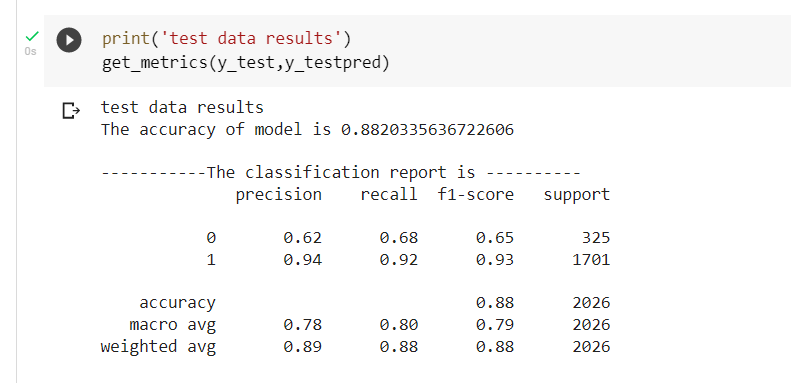



##### Decision Tree Model

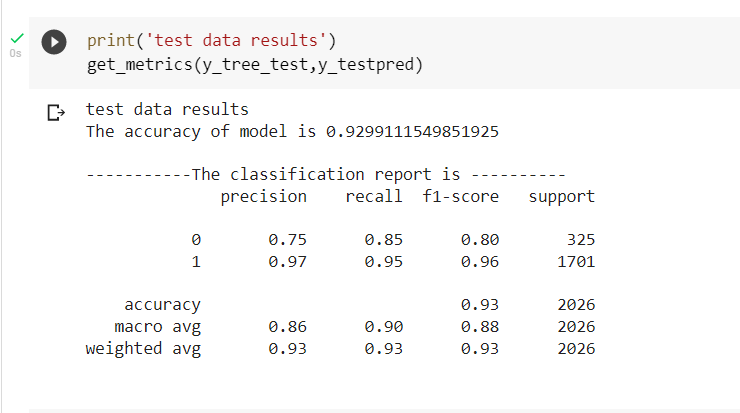



##### Random Forest Classifier


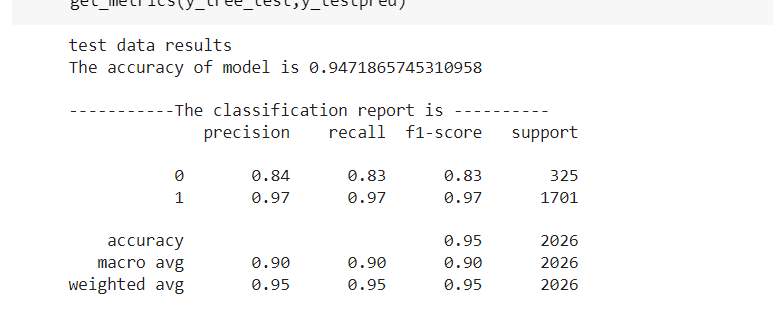



##### Adaboost classifier

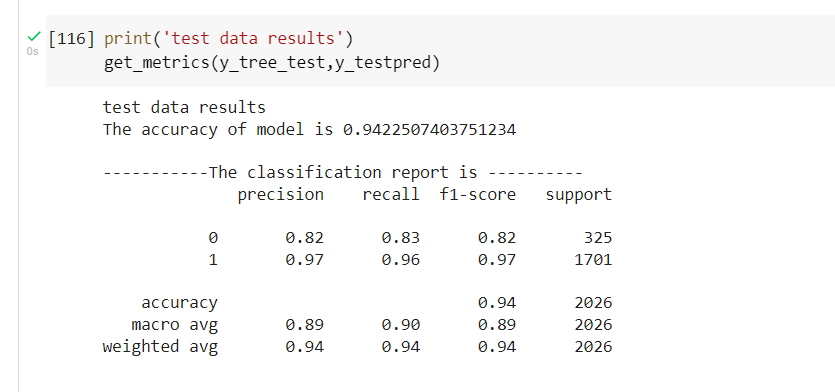


##### XGBoost Classifier

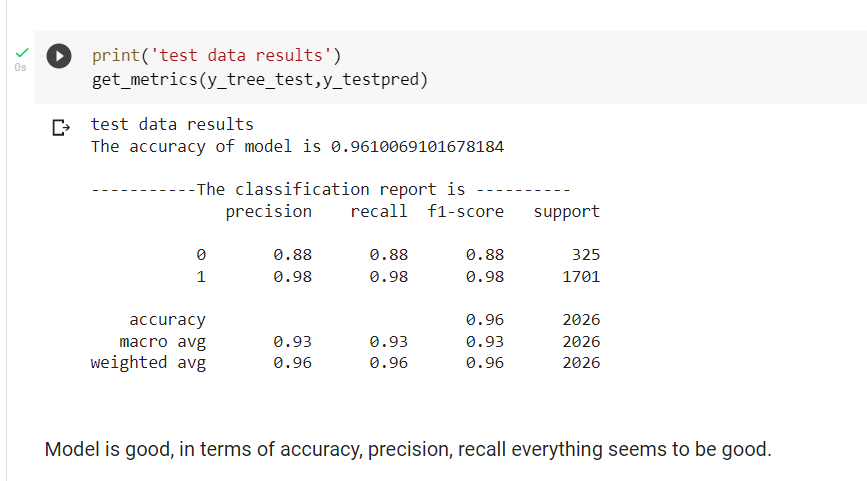


##### Light GBM classifier

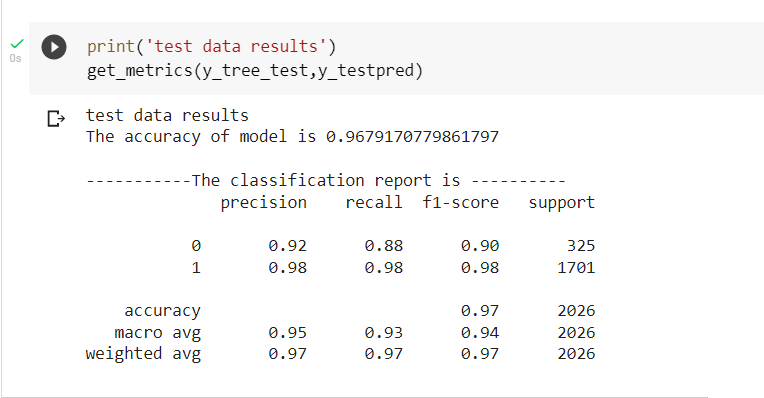

##### Final Observations

1. Comparing all the model metrics, i could find that XGBoost classifier model is better. It has recall, precision, accuracy good overall. [ Light gbm model seems to be little overfitting after and before tuning]

2. Second comes adaboost model which has good values of accuracy, precision and recall.

3. Third comes the RandomForest Classifier model

4. Fourth will be Decision tree classifier model

5. Fifth will be logistic regression model



#### For the study purposes, we can choose Xgboost model :) :)

###### ---------------------------------------------------------------------------------------------------------END----------------------------------------------------------------------------------------------------------------